# Pb scavenging parameterization

BLING ends in April, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import modules.mapping_functions as mf

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

#### Load files

In [3]:
# ANHA12 mesh grid:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

#### Functions:

In [4]:
def open_file(folder, year, month):    
    
    base_folder = '/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/'
    particle_file = xr.open_dataset(f'{base_folder}{folder}Pb_scavenging_y{year}m{month:02}.nc')
   
    bio_part   = particle_file['biogenic']
    litho_part = particle_file['lithogenic']
    
    return bio_part, litho_part

In [5]:
def plot_particle_fields(fig, ax, variable, depth_slice=(0,18), maxv=1):
    variable_slice = np.mean(variable[depth_slice[0]:depth_slice[1],:,:], axis=0)

    # Map -----------------------------------------------------------------------------------------------------
    proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax)
    proj.drawcoastlines(color='#373736', linewidth=1.0);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    
    x, y = proj(mesh_lon, mesh_lat)
    proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth

    # Model domain variable field ----------------------------------------------------------------------------
    x_Pb, y_Pb = proj(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    CB2 = proj.pcolormesh(x_Pb, y_Pb, variable_slice, cmap=cmocean.cm.matter, vmin=0, vmax=maxv)
        
    # Colorbar: 
    CBar2 = plt.colorbar(CB2, ax=ax, orientation='vertical', shrink=0.5)
    CBar2.ax.tick_params(labelsize=6) 
#     CBar2.set_label('', fontsize=6)
    
    ax.set_title(f'Depth slice: {depths[depth_slice[0]]:.0f}-{depths[depth_slice[1]]:.0f} m', fontsize=6)
   
    return

" Pb has been shown to be rapidly incorporated in biogenic particles by passive adsorption from the dissolved pool on the phytoplankton (Burnett and Patterson, 1980; Schaule and Patterson, 1981; Flegal and Patterson, 1983). This phytoplankton is theo ingested by primary and
secondary consumers, wich produce fecal aggregates that are the major component of particles of large diameter."

Burnett and Patterson, 1980: "Its non-conservative behavior in open oceans is attributed to biological transport processes, which include rapid passive uptake of the metal on phytoplankton surfaces, followed by zooplankton ingestion and vertical transport to sediments via fecal pellets [6,7]. The initial bioaccumulation step is due to the element's high affinity for organic complexes [7,8] and the prevalence
of its biogeochemical analogue, calcium, as a structural component of phytoplankton."

https://pubs.acs.org/doi/pdf/10.1021/es049434a

"Heavy metals adsorbed onto aeolian particles can be transported over long distances (Hamelin et al.. 1989; Nriagu, 1989; Buat-Mtnard, 1993), and when these particles reach the surface of the ocean, some associated elements are largely dissolved in the upper water masses (Flegal and Patterson, 1983). However, a non-negligible fraction may be reincorporated into particles, largely by biological processes, and reach the bottom of the ocean to be incorporated into sediments (V&on et al., 1987; Hamelin et al., 1990)."

https://www.sciencedirect.com/science/article/pii/030442039400056J

#### Distribution of scavenging values

In [6]:
# Scavenging particle fields:
bio_2015   = np.empty((12,50,isize,jsize)); bio_2015[:]   = np.nan;
litho_2015 = np.empty((12,50,isize,jsize)); litho_2015[:] = np.nan;

for month in range(1,13):
    biom, lithom = open_file('particle8-2/', 2015, month)
    bio_2015[month-1,:,:,:]   = biom[:,imin:imax,jmin:jmax]
    litho_2015[month-1,:,:,:] = lithom[:,imin:imax,jmin:jmax]

In [7]:
mesh_tile = np.tile(mesh_bathy[:,imin:imax,jmin:jmax], (12,1,1,1))

In [15]:
# Mask land values:
bio_masked   = np.ma.masked_where((mesh_tile<0.1), bio_2015)
litho_masked = np.ma.masked_where((mesh_tile<0.1), litho_2015)

# Calculate scavenging rate based on particle fields:
kp   = 1e-5 # per second
beta = 0.03 # fraction
scavenging_rate = kp * (litho_masked + bio_masked)

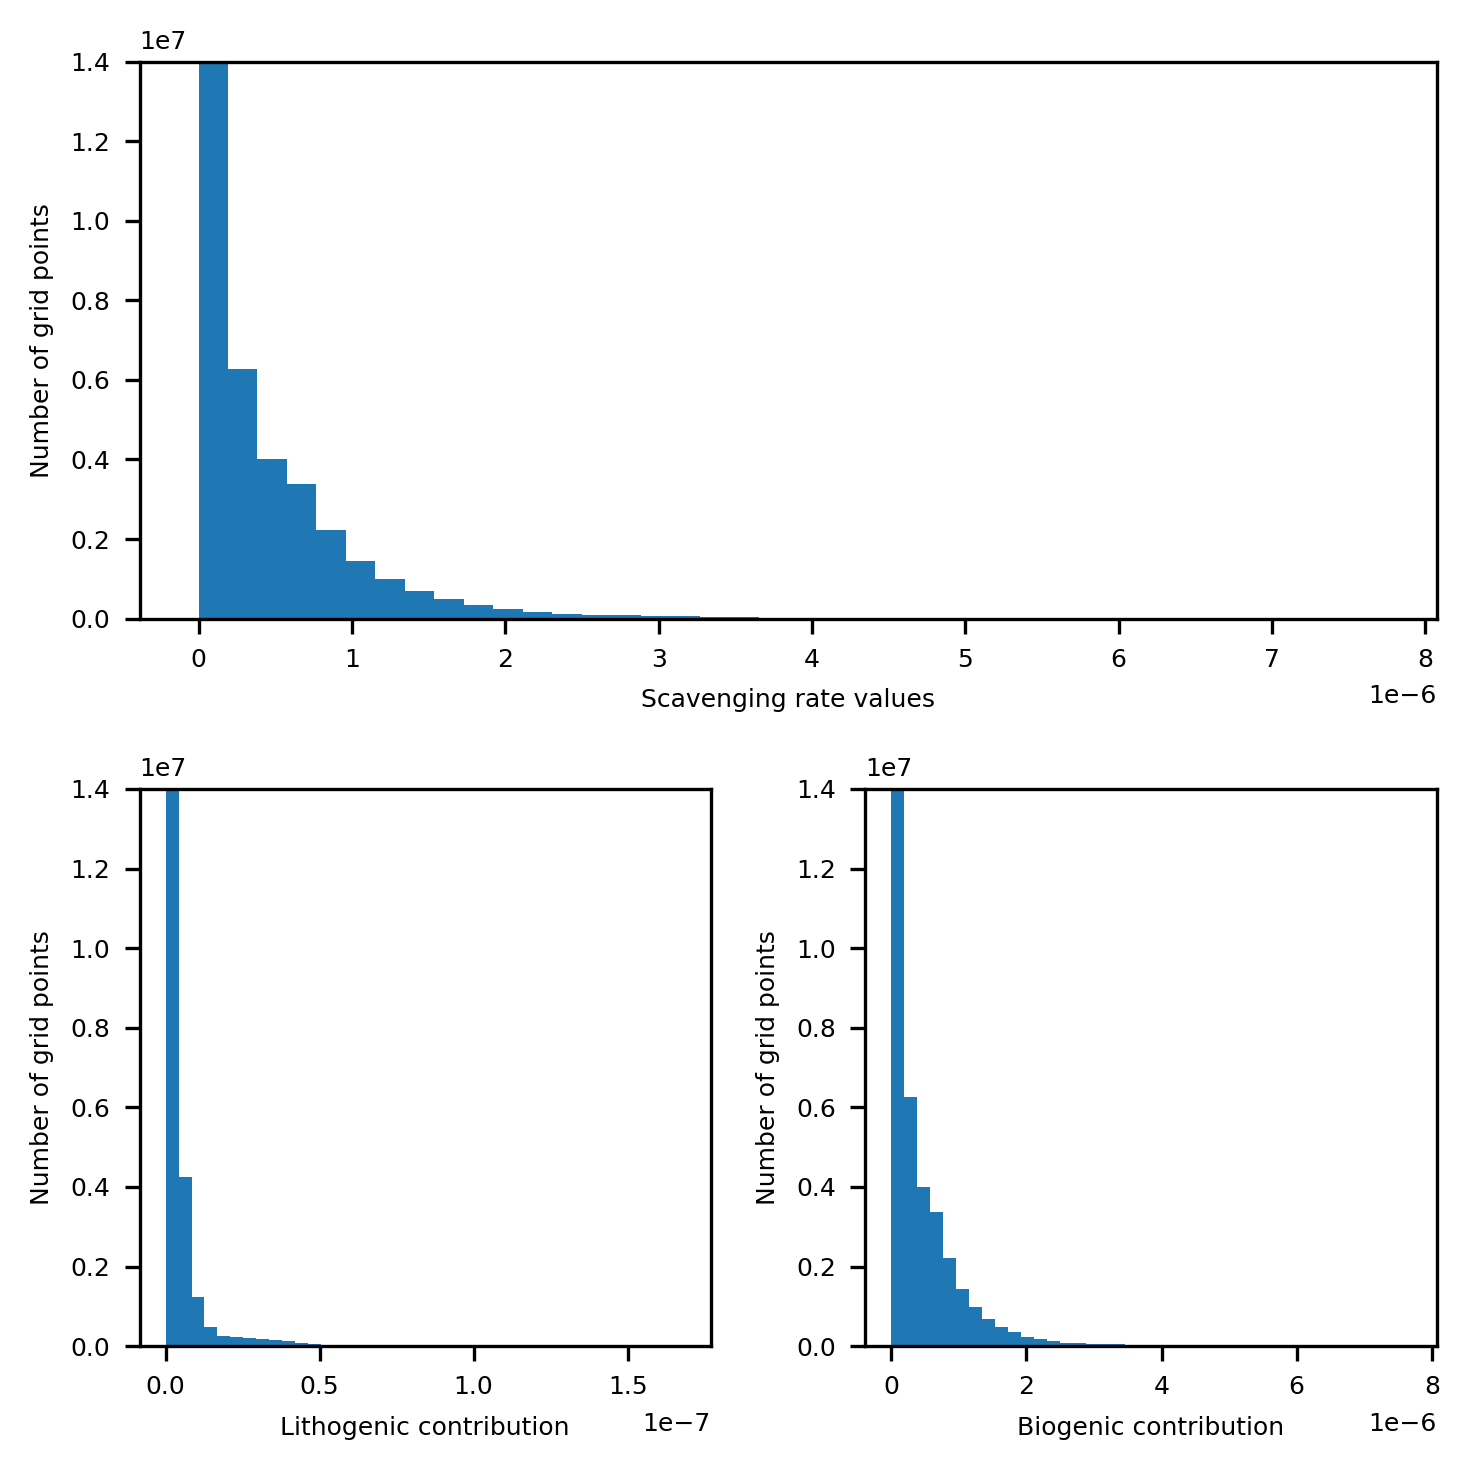

In [16]:
fig = plt.figure(figsize=(5,5), dpi=300)
gs  = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

for axis in [ax1, ax2, ax3]:
    axis.set_ylim(0,1.4e7)
    axis.set_xlim(0,7e-6)
    axis.set_ylabel('Number of grid points', fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    t = axis.yaxis.get_offset_text()
    r = axis.xaxis.get_offset_text()
    t.set_size(6); r.set_size(6);

nbins=40
    
# General scavenging rate histogram:
ax1.hist(scavenging_rate.compressed(), bins=nbins);
ax1.set_xlabel('Scavenging rate values', fontsize=6)

# Lithogenic contribution to scavenging histogram:
ax2.hist(litho_masked.compressed()*kp, bins=nbins);
ax2.set_xlabel('Lithogenic contribution', fontsize=6)

# Biogenic contribution to scavenging histogram:
ax3.hist(bio_masked.compressed()*kp, bins=nbins);
ax3.set_xlabel('Biogenic contribution', fontsize=6)

plt.tight_layout()

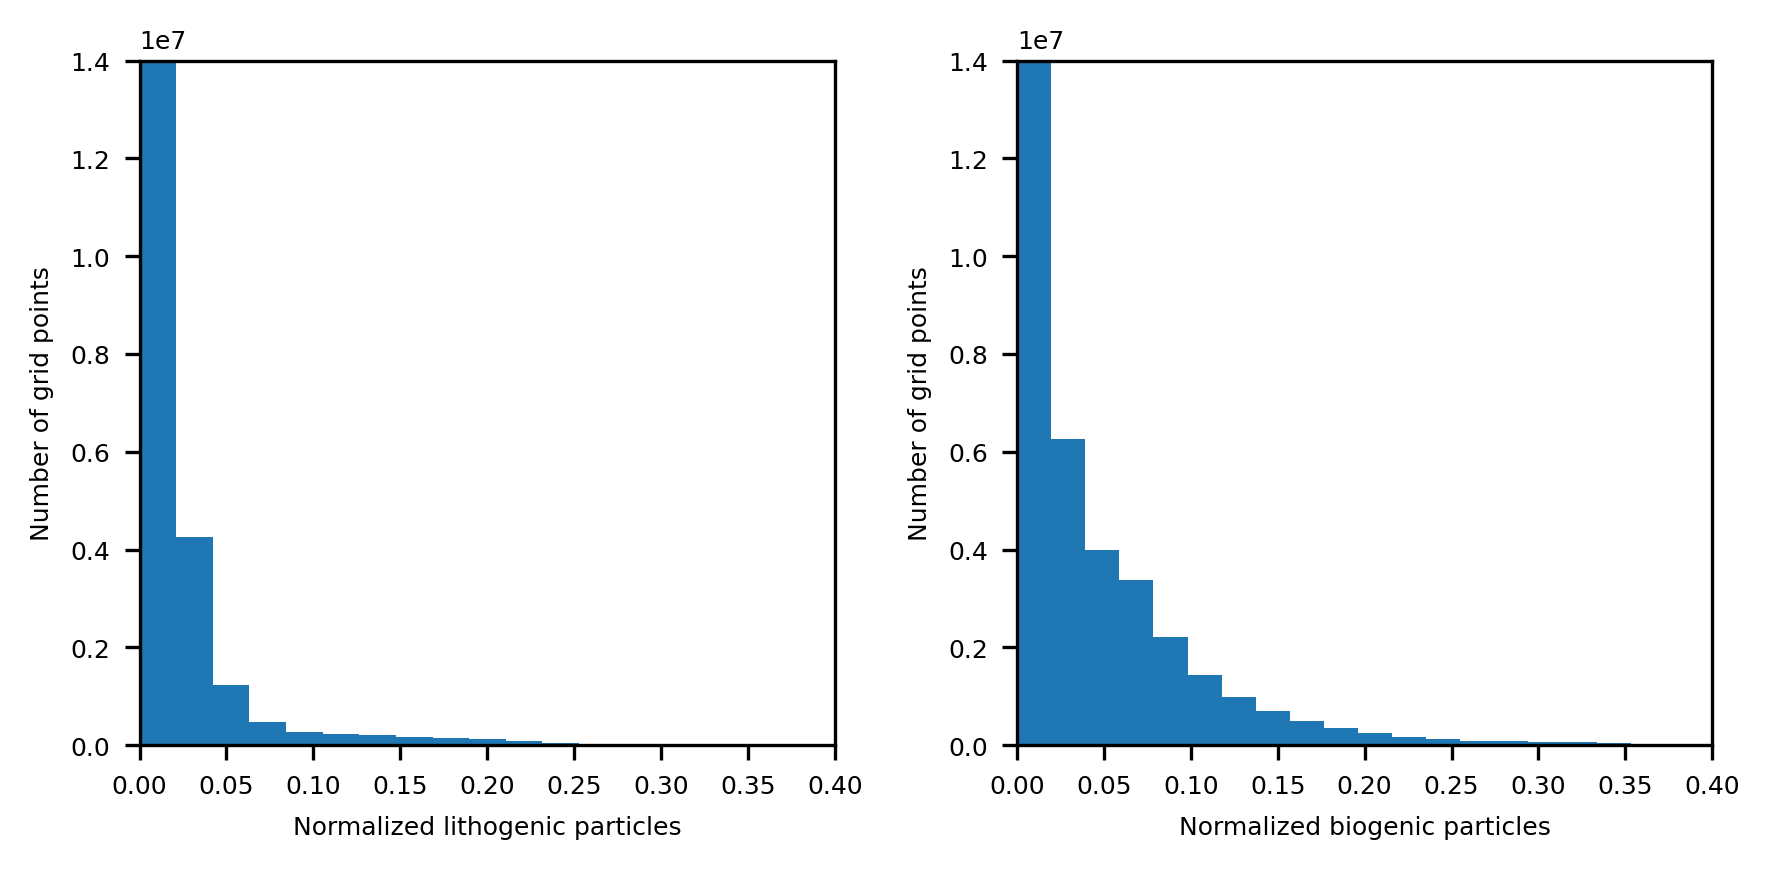

In [33]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=300)

for axis in ax.ravel():
    axis.set_ylim(0,1.4e7)
    axis.set_xlim(0,0.4)
    axis.set_ylabel('Number of grid points', fontsize=6)
    axis.tick_params(axis='both', labelsize=6)
    t = axis.yaxis.get_offset_text()
    r = axis.xaxis.get_offset_text()
    t.set_size(6); r.set_size(6);

nbins=40
    
# Lithogenic contribution to scavenging histogram:
ax[0].hist(litho_masked.compressed()*(1/0.02), bins=nbins);
ax[0].set_xlabel('Normalized lithogenic particles', fontsize=6)

# Biogenic contribution to scavenging histogram:
ax[1].hist(bio_masked.compressed()*(1/0.98), bins=nbins);
ax[1].set_xlabel('Normalized biogenic particles', fontsize=6)

plt.tight_layout()

#### Normalized particle fields:

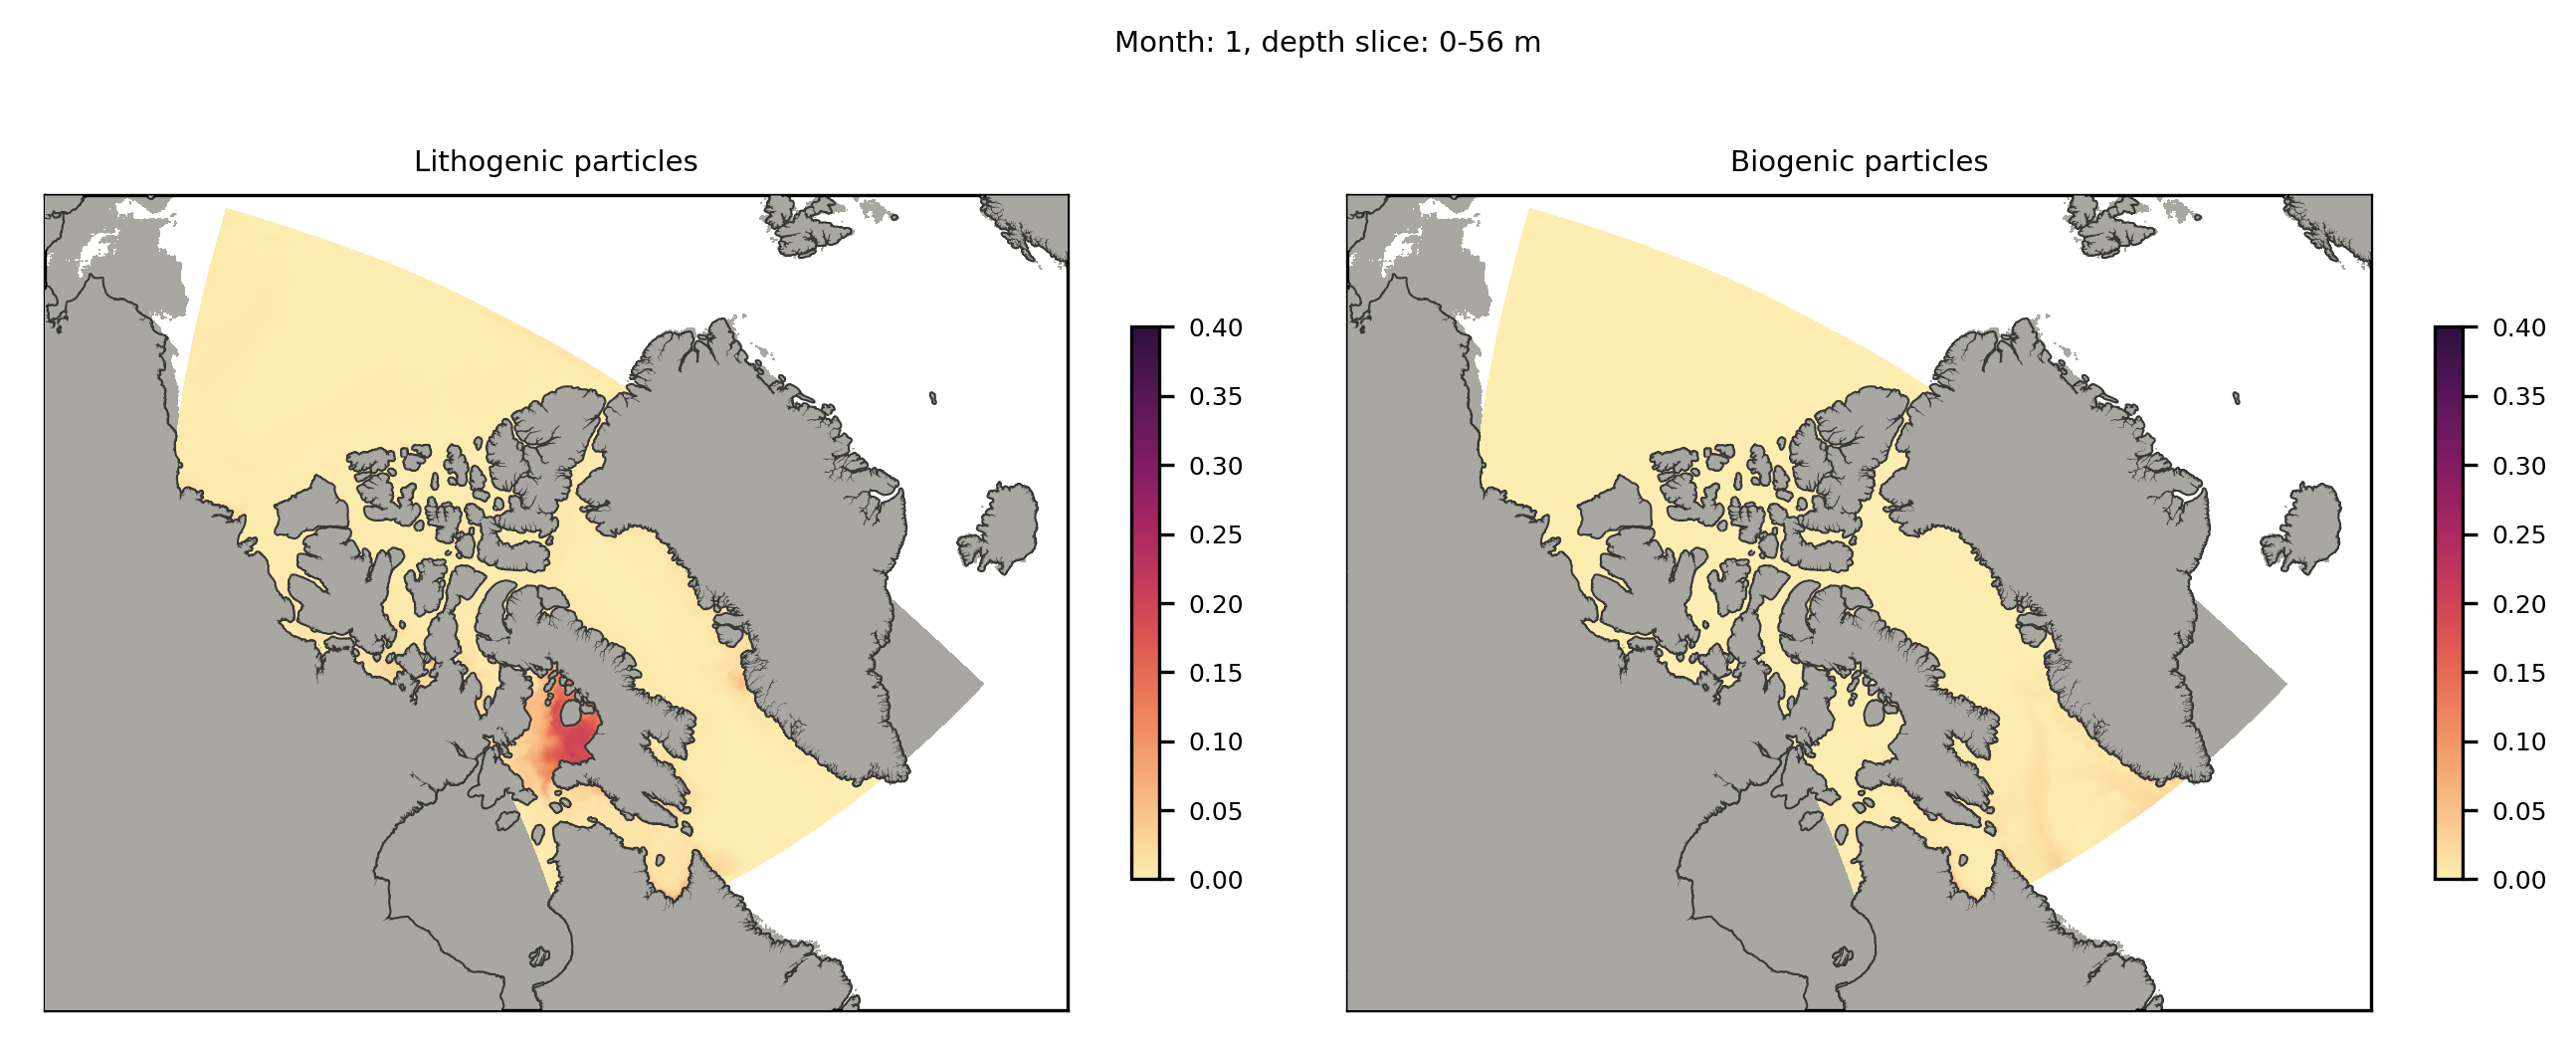

In [ ]:
month = 0
deps  = (0,18)

fig, ax = plt.subplots(1,2,figsize=(9, 4), dpi=300)

plot_particle_fields(fig, ax[0], litho_masked[month,:,:,:]*(1/0.02), depth_slice=deps, maxv=0.4)
plot_particle_fields(fig, ax[1], bio_masked[month,:,:,:]*(1/0.98), depth_slice=deps, maxv=0.4)

fig.suptitle(f'Month: {month+1}, depth slice: {depths[deps[0]]:.0f}-{depths[deps[1]]:.0f} m', fontsize=7)
ax[0].set_title('Lithogenic particles', fontsize=7)
ax[1].set_title('Biogenic particles', fontsize=7)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)

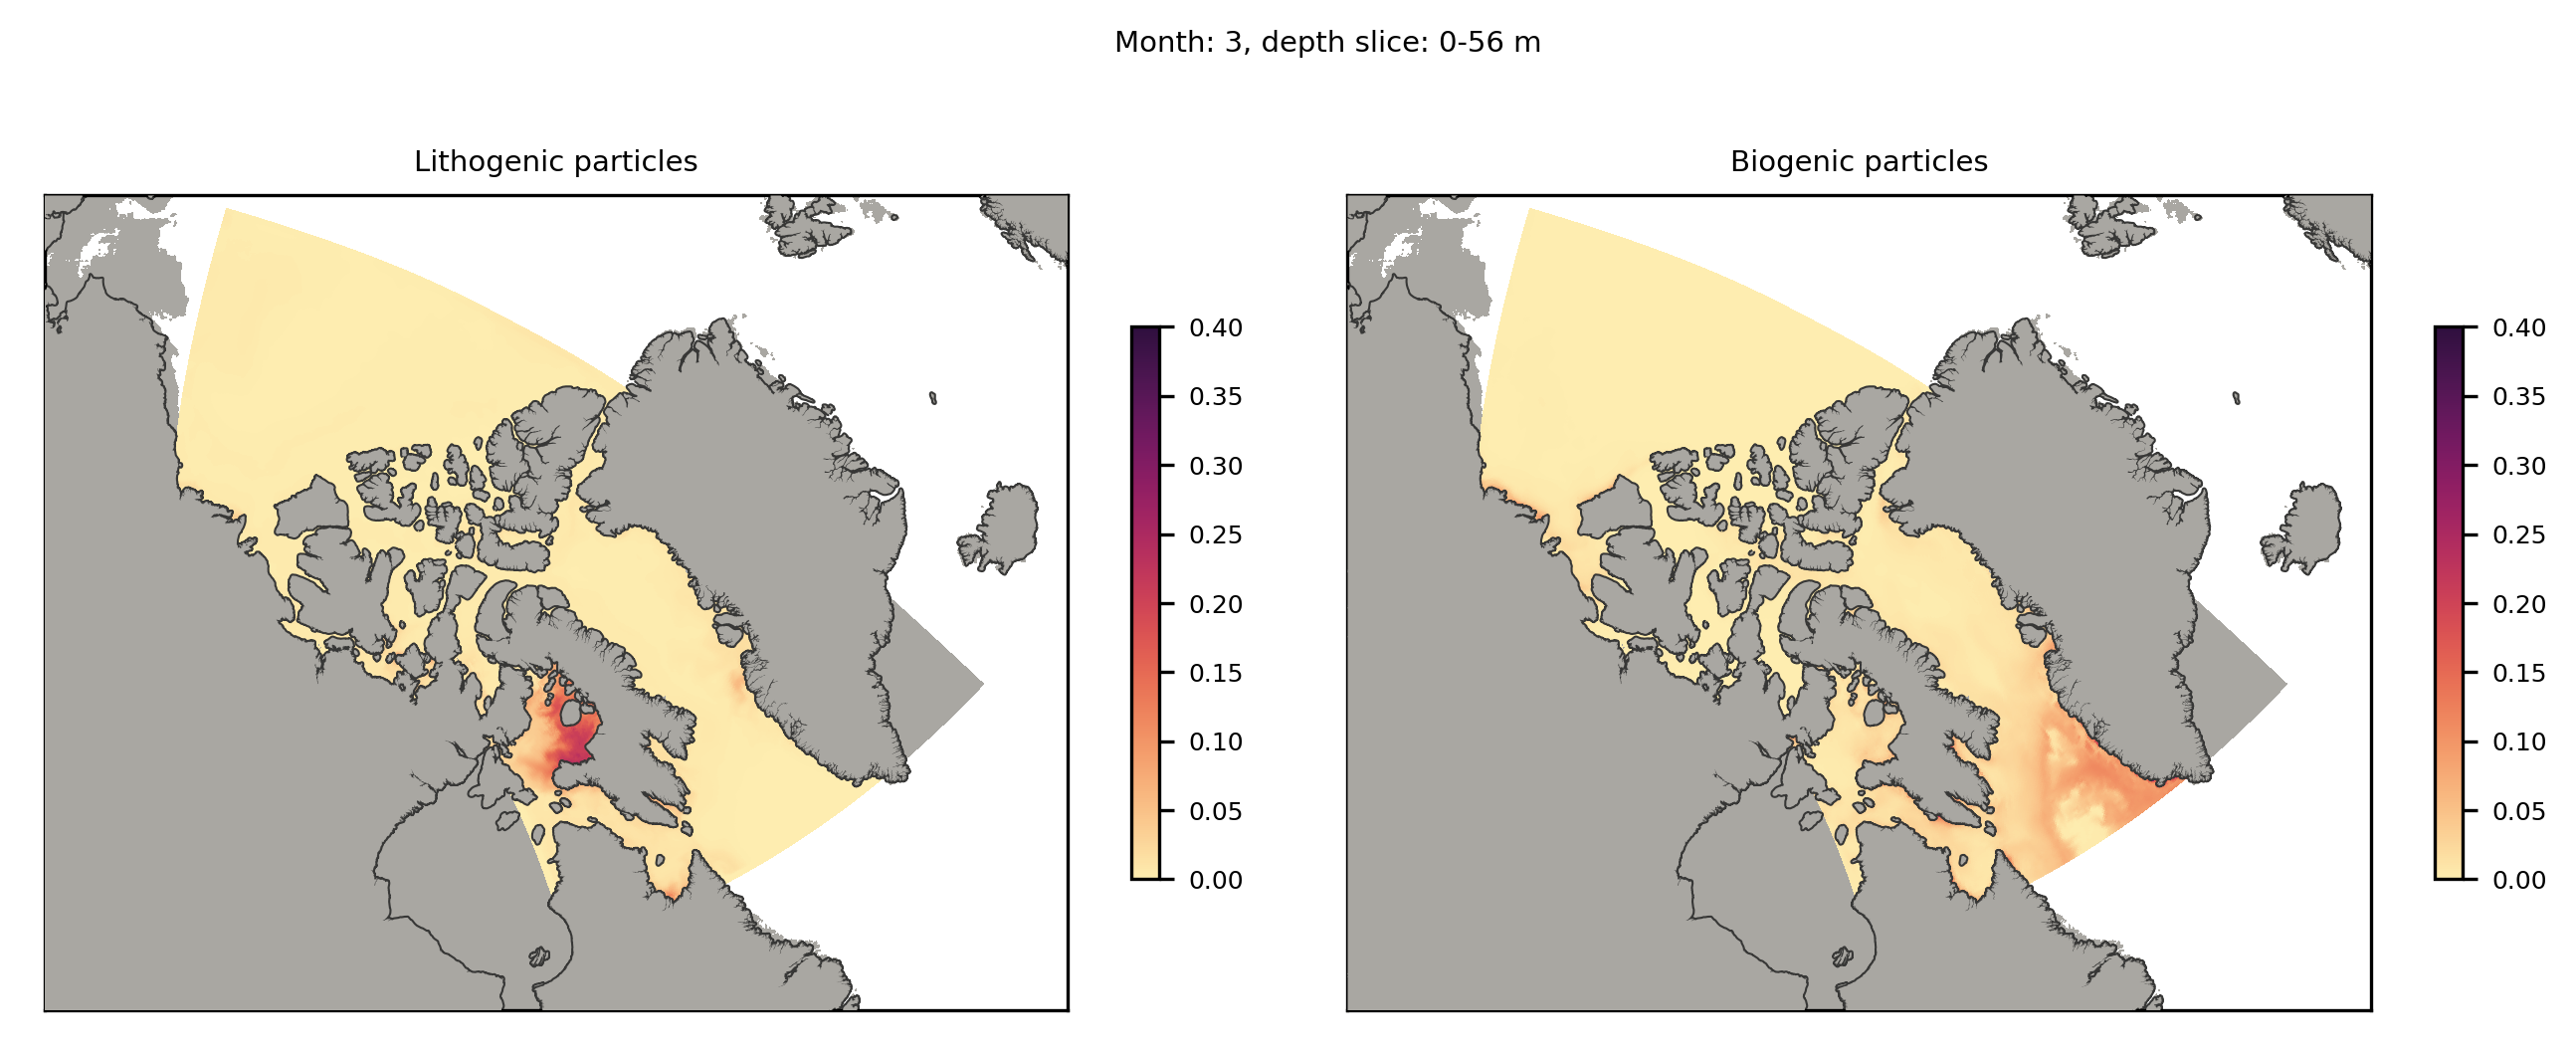

In [ ]:
month = 2
deps  = (0,18)

fig, ax = plt.subplots(1,2,figsize=(9, 4), dpi=300)

plot_particle_fields(fig, ax[0], litho_masked[month,:,:,:]*(1/0.02), depth_slice=deps, maxv=0.4)
plot_particle_fields(fig, ax[1], bio_masked[month,:,:,:]*(1/0.98), depth_slice=deps, maxv=0.4)

fig.suptitle(f'Month: {month+1}, depth slice: {depths[deps[0]]:.0f}-{depths[deps[1]]:.0f} m', fontsize=7)
ax[0].set_title('Lithogenic particles', fontsize=7)
ax[1].set_title('Biogenic particles', fontsize=7)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)

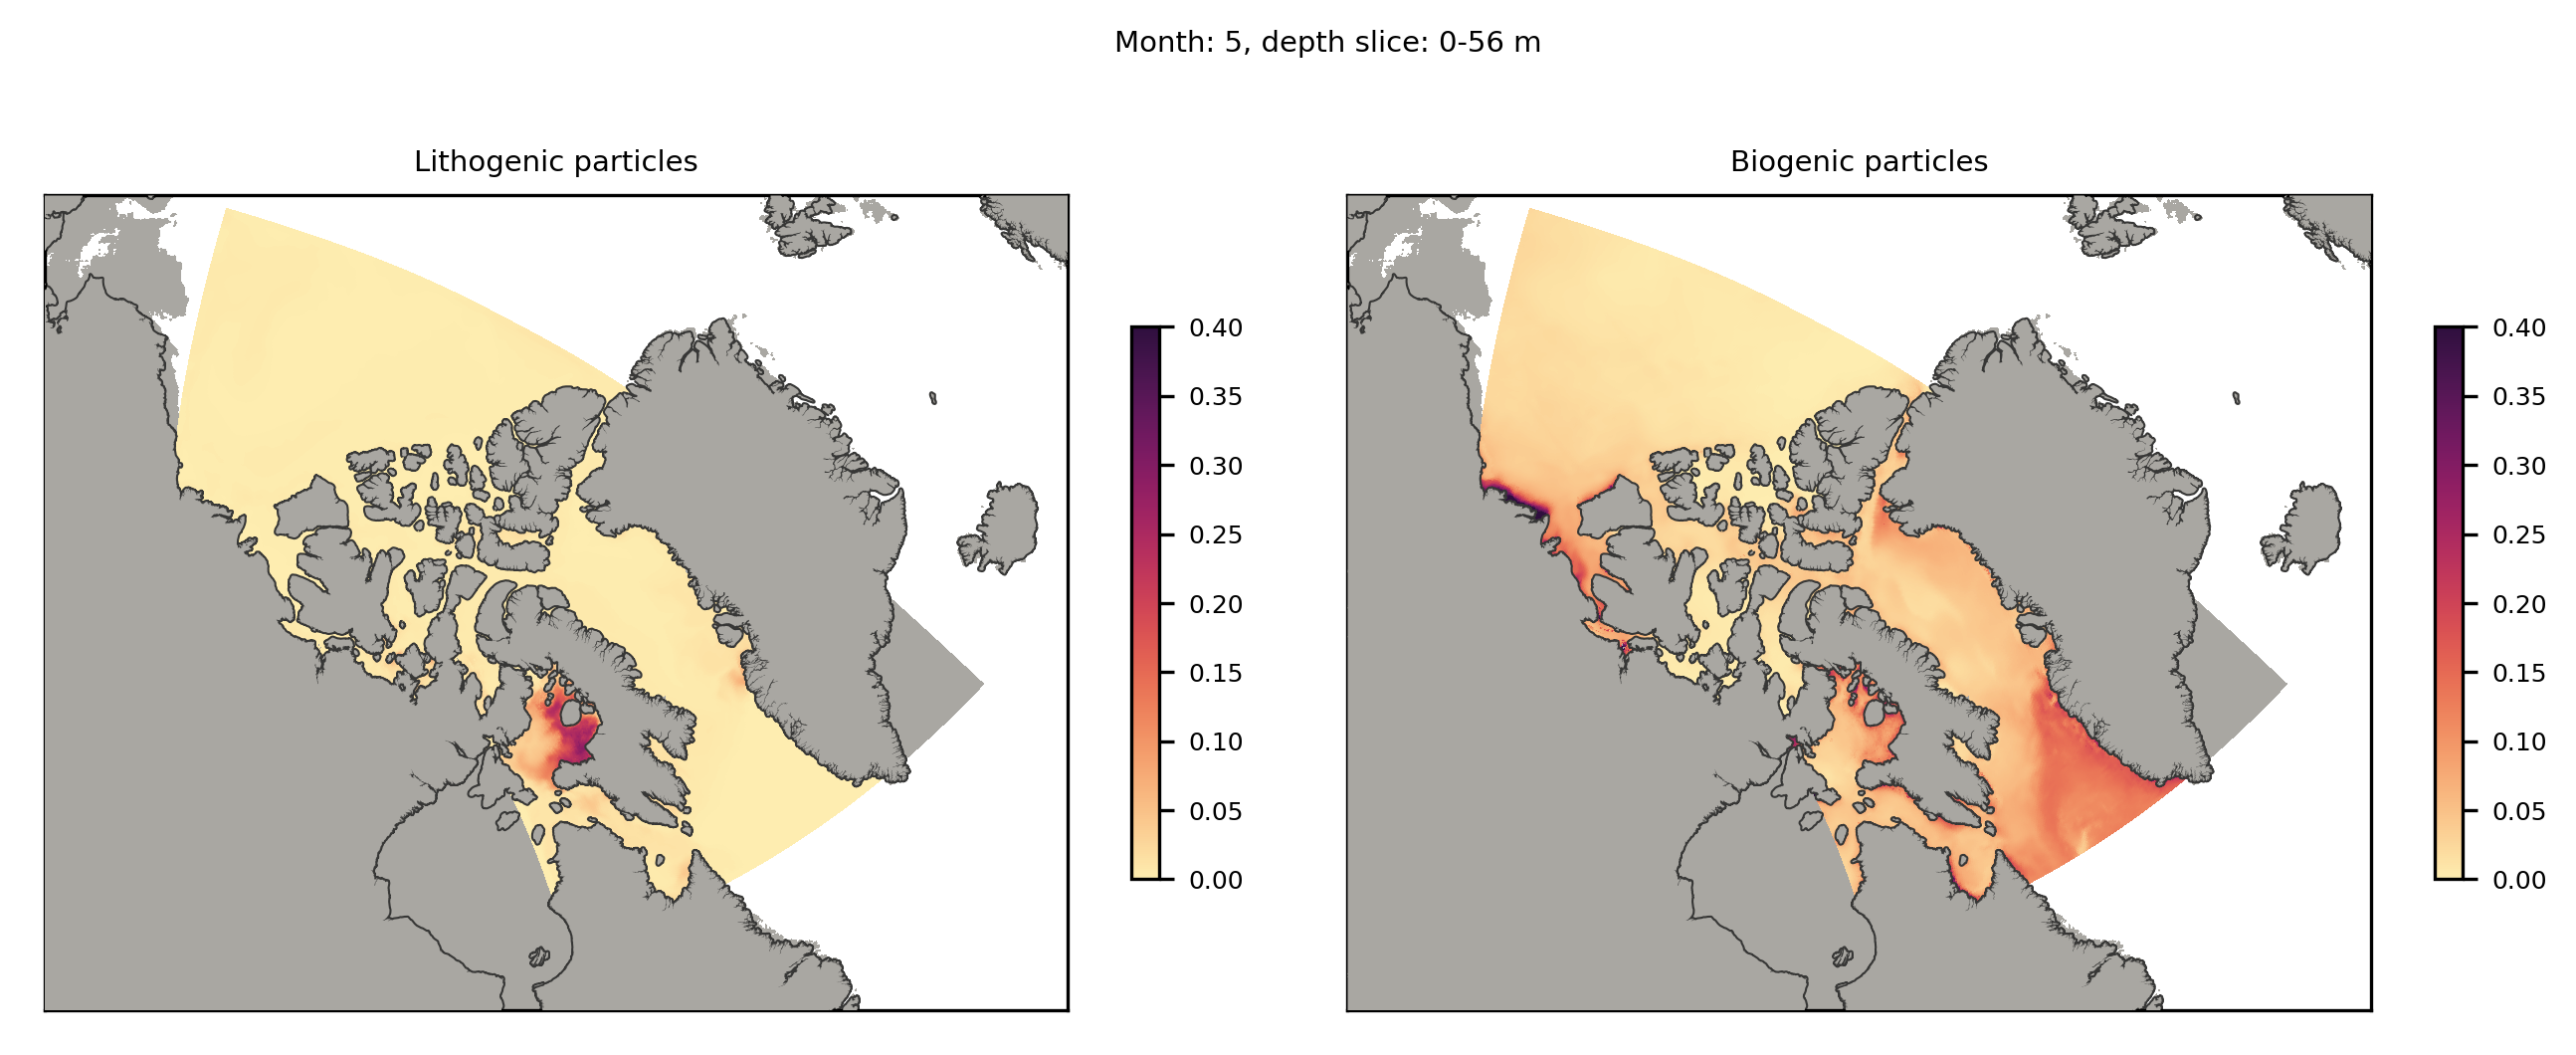

In [ ]:
month = 4
deps  = (0,18)

fig, ax = plt.subplots(1,2,figsize=(9, 4), dpi=300)

plot_particle_fields(fig, ax[0], litho_masked[month,:,:,:]*(1/0.02), depth_slice=deps, maxv=0.4)
plot_particle_fields(fig, ax[1], bio_masked[month,:,:,:]*(1/0.98), depth_slice=deps, maxv=0.4)

fig.suptitle(f'Month: {month+1}, depth slice: {depths[deps[0]]:.0f}-{depths[deps[1]]:.0f} m', fontsize=7)
ax[0].set_title('Lithogenic particles', fontsize=7)
ax[1].set_title('Biogenic particles', fontsize=7)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)

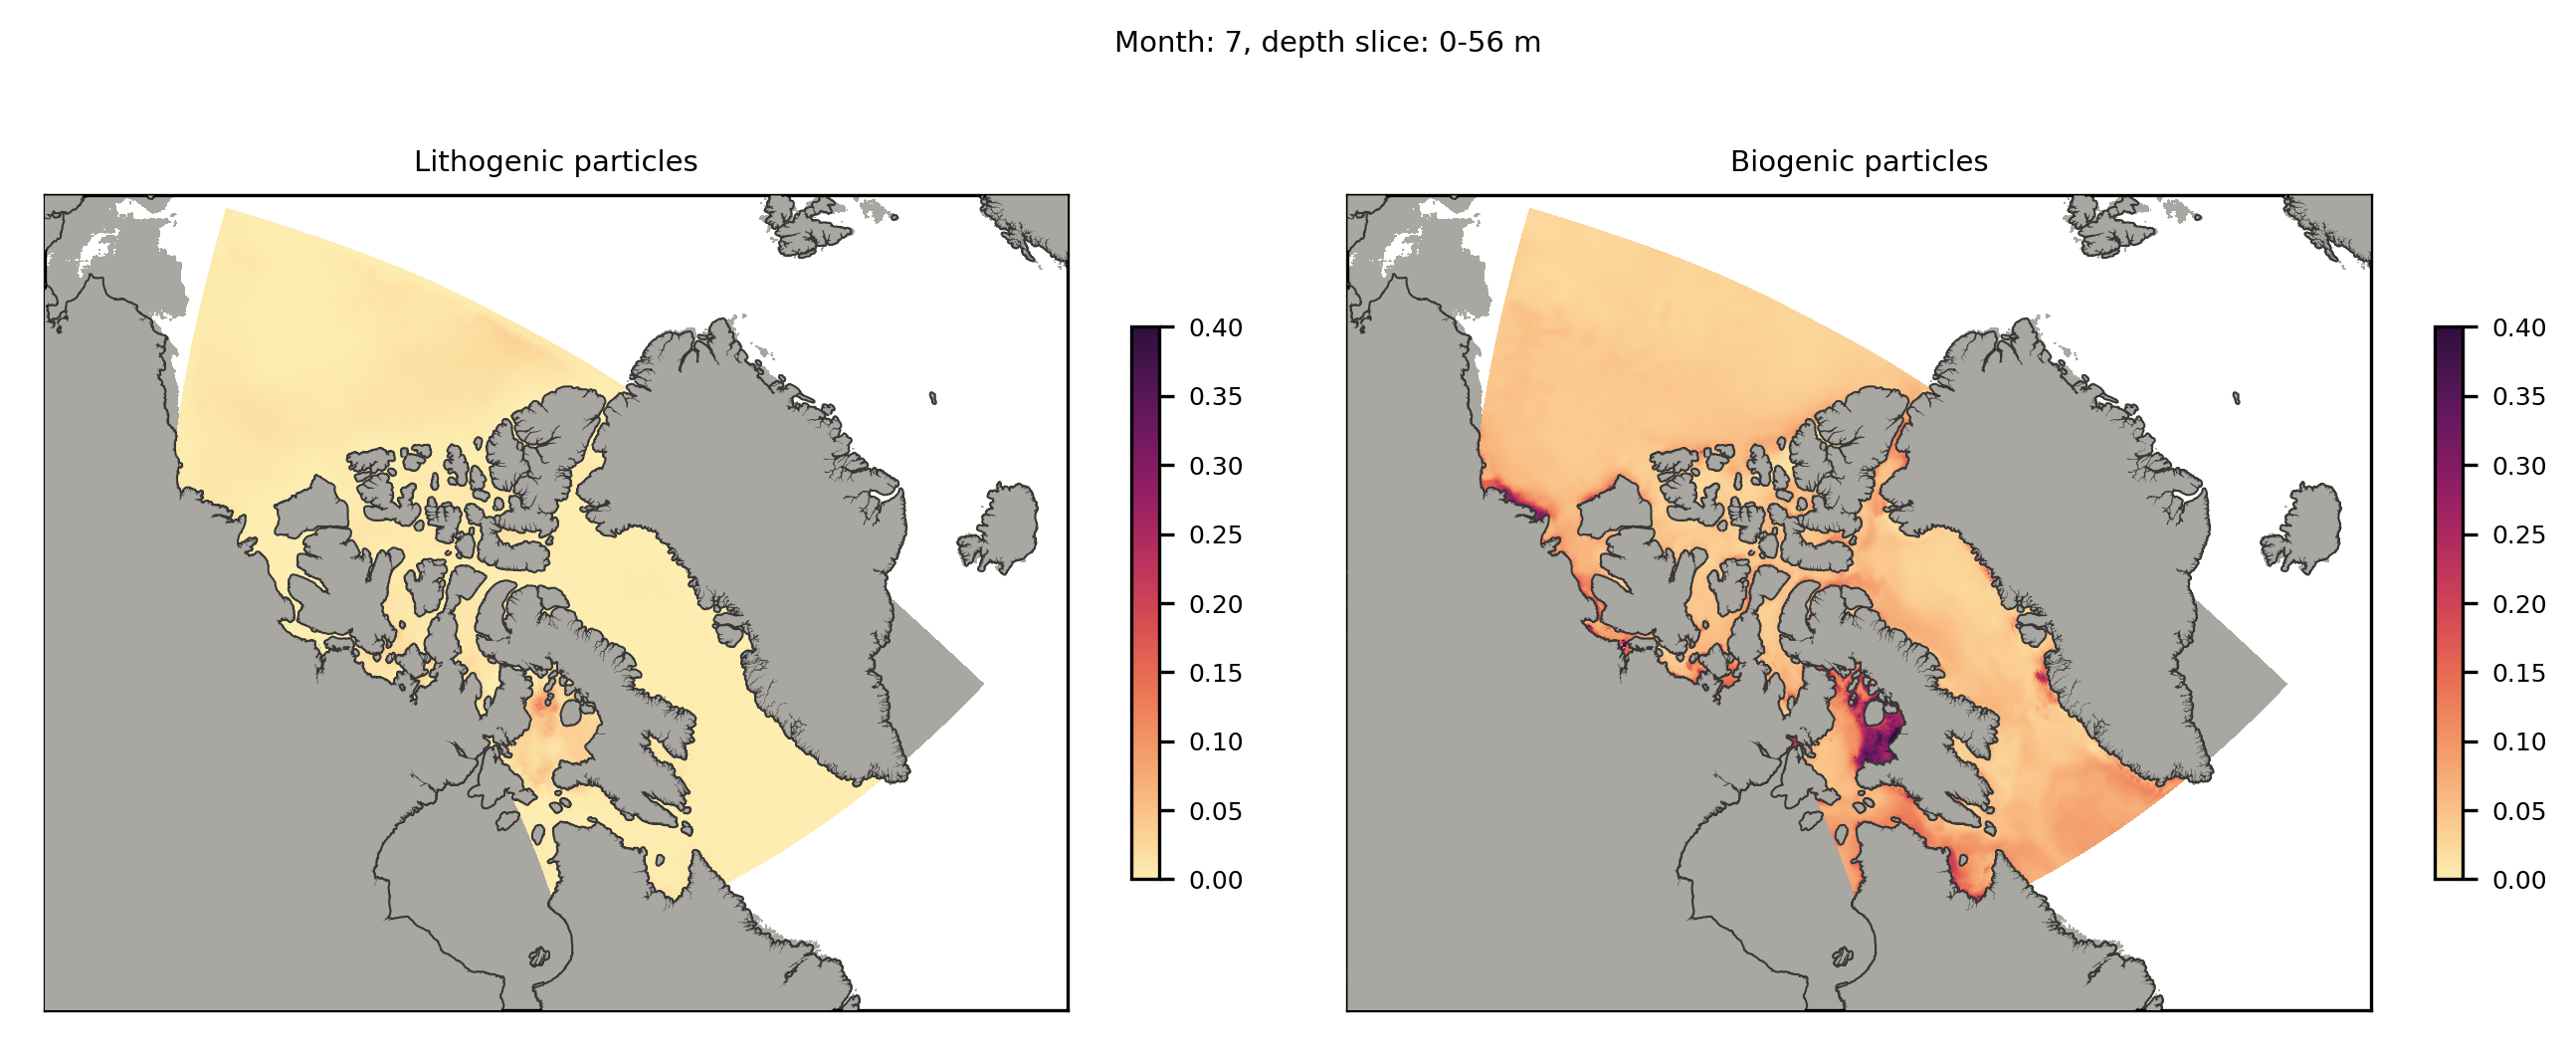

In [24]:
month = 6
deps  = (0,18)

fig, ax = plt.subplots(1,2,figsize=(9, 4), dpi=300)

plot_particle_fields(fig, ax[0], litho_masked[month,:,:,:]*(1/0.02), depth_slice=deps, maxv=0.4)
plot_particle_fields(fig, ax[1], bio_masked[month,:,:,:]*(1/0.98), depth_slice=deps, maxv=0.4)

fig.suptitle(f'Month: {month+1}, depth slice: {depths[deps[0]]:.0f}-{depths[deps[1]]:.0f} m', fontsize=7)
ax[0].set_title('Lithogenic particles', fontsize=7)
ax[1].set_title('Biogenic particles', fontsize=7)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)

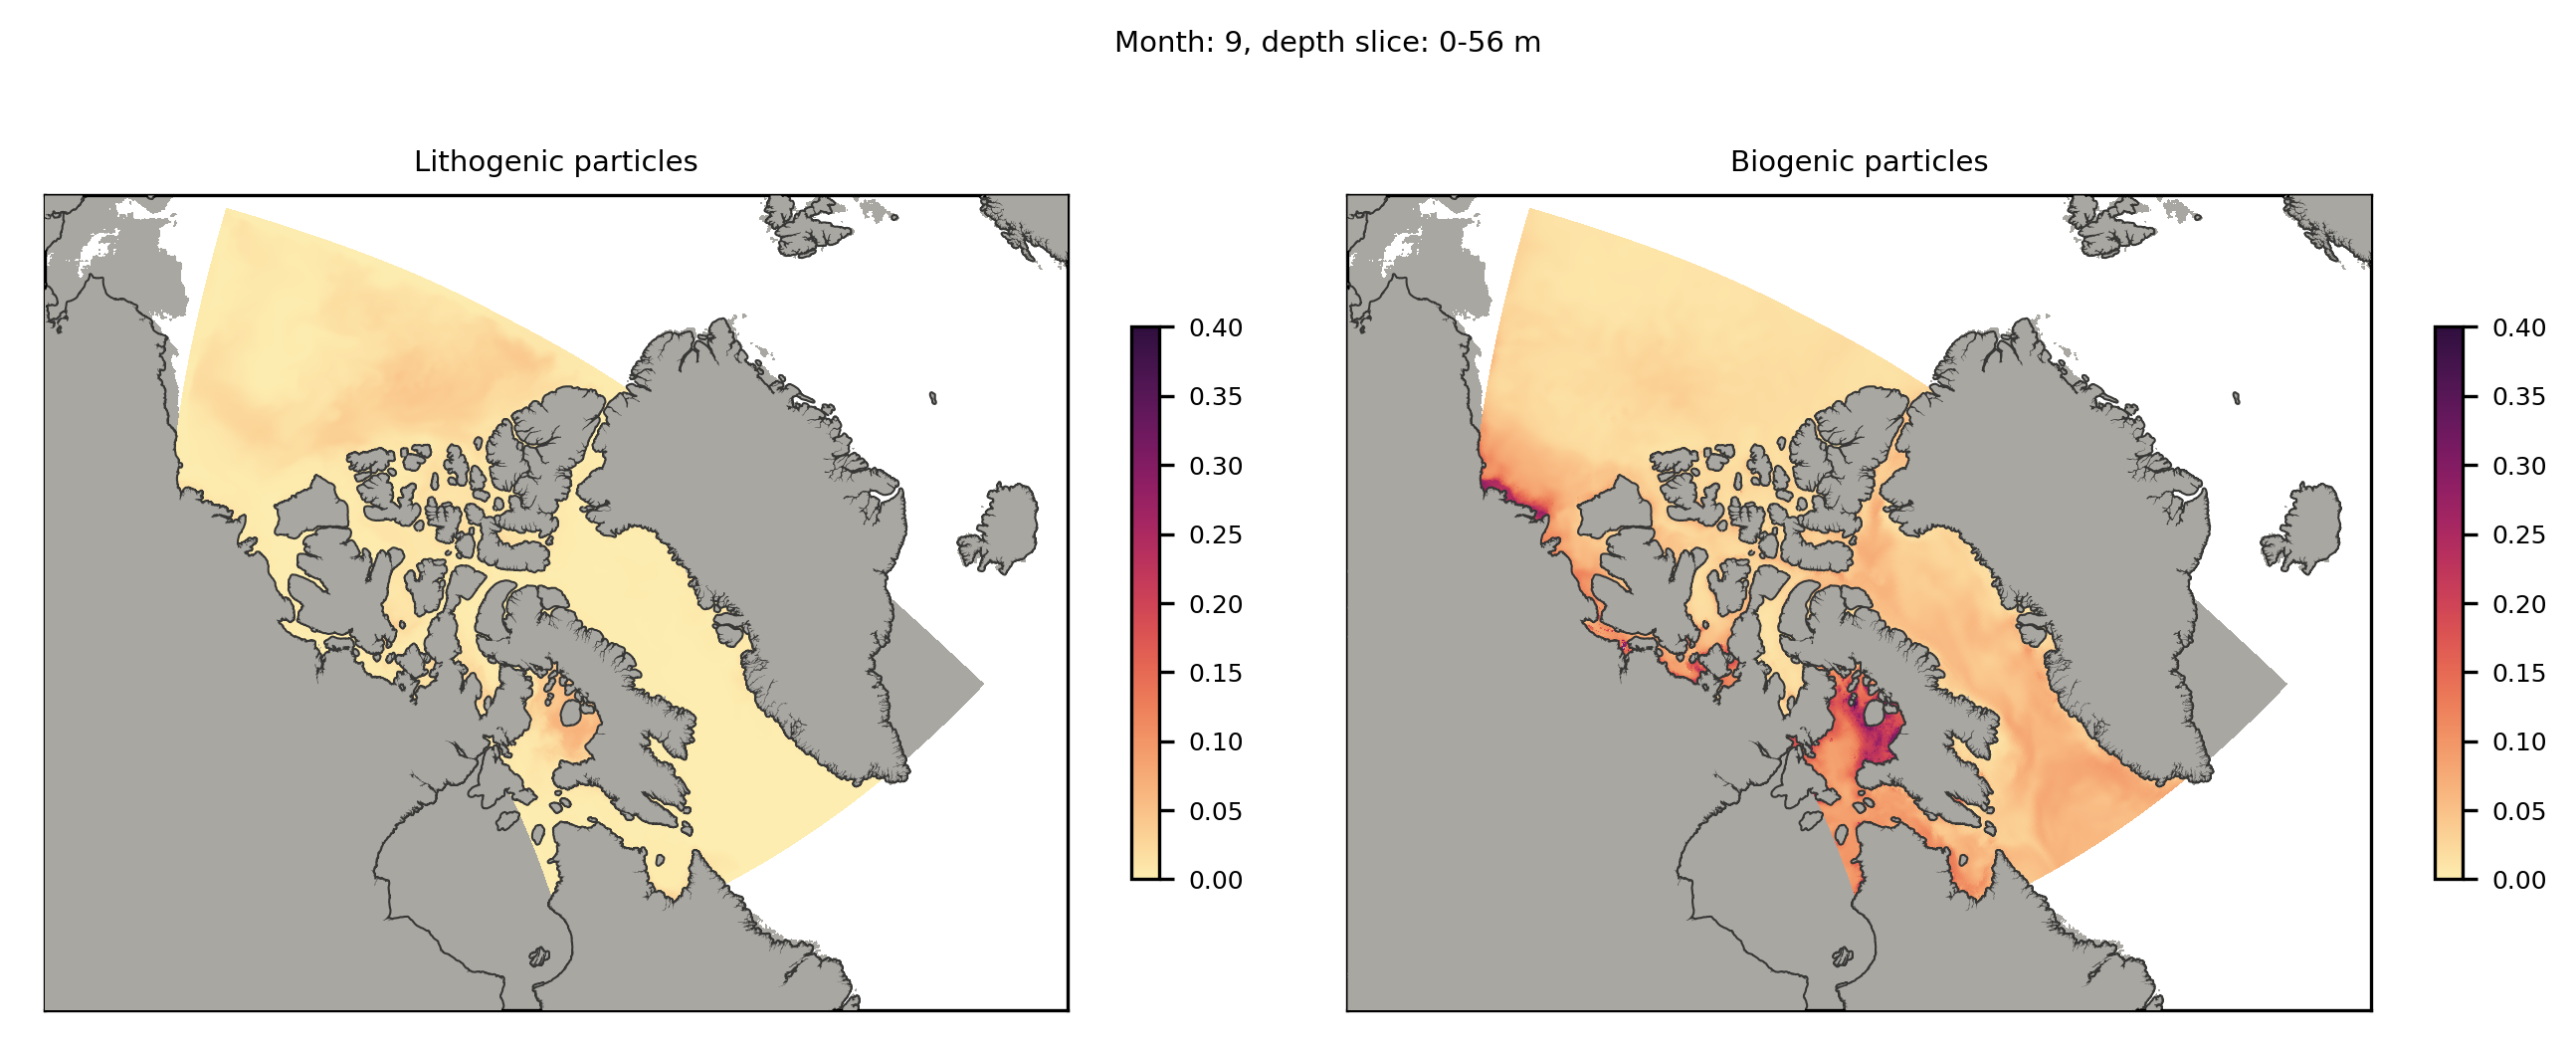

In [28]:
month = 8
deps  = (0,18)

fig, ax = plt.subplots(1,2,figsize=(9, 4), dpi=300)

plot_particle_fields(fig, ax[0], litho_masked[month,:,:,:]*(1/0.02), depth_slice=deps, maxv=0.4)
plot_particle_fields(fig, ax[1], bio_masked[month,:,:,:]*(1/0.98), depth_slice=deps, maxv=0.4)

fig.suptitle(f'Month: {month+1}, depth slice: {depths[deps[0]]:.0f}-{depths[deps[1]]:.0f} m', fontsize=7)
ax[0].set_title('Lithogenic particles', fontsize=7)
ax[1].set_title('Biogenic particles', fontsize=7)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)